In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sqlite3 as sql

from utils import *

sns.set()
con = sql.connect("./problems.db")

con.execute(('CREATE TABLE IF NOT EXISTS "problems" ('
  '"Problem" TEXT,'
  '"Algorithm" TEXT,'
  '"N" INTEGER,'
  '"T" INTEGER,'
  '"SA_initial_temperature" REAL,'
  '"SA_cooling_factor" REAL,'
  '"GA_population" REAL,'
  '"GA_mate_number" REAL,'
  '"GA_mutate_number" REAL,'
  '"MIMIC_samples" REAL,'
  '"MIMIC_to_keep" REAL,'
  '"Error" REAL,'
  '"Time" REAL,'
  '"Iteration" INTEGER'
');'))
#con.execute('CREATE INDEX "PB" on "problems" ("Problem");')
#con.execute('CREATE INDEX "ALG" on "problems" ("Algorithm");')
con.enable_load_extension(True)
con.load_extension("./extension-functions")

In [29]:
def generate_sql_z_query(z_name: str):
    where_close = ""
    first_key = True
    for k, lf in filters.items():
        if first_key:
            first_key = False
        else:
            where_close += "AND "
        where_close += "("
        first = True
        for v in lf:
            if not first:
                where_close += " OR "
            else:
                first = False
            where_close += str(k)+"='"+str(v)+"'"
        where_close += ") "
    return "SELECT DISTINCT "+z_name+" FROM problems WHERE "+where_close

def generate_sql_xy_query(x_name: str, y_name: str, z_name: str, z_value, filters: dict):
    where_close = z_name+" = '"+str(z_value)+"' "
    for k, lf in filters.items():
        where_close += "AND ("
        first = True
        for v in lf:
            if not first:
                where_close += " OR "
            else:
                first = False
            where_close += str(k)+"='"+str(v)+"'"
        where_close += ") "
    return ("SELECT "+x_name+","
            "min("+y_name+") as min,"
            "max("+y_name+") as max,"
            "median("+y_name+") as median,"
            "avg("+y_name+") as mean "
            "FROM problems "
            "WHERE "+where_close+""
            "GROUP BY "+x_name)

def consolidate_data_from_db(con, x_name: str, y_name: str, z_name: str, filters: dict):
    z_value_df = pd.read_sql_query(generate_sql_z_query(z_name), con)
    cd = dict()
    for i in z_value_df.get(z_name):
        query = generate_sql_xy_query(x_name, y_name, z_name, i, filters)
        print("Selecting data for", z_name, "=", i)
        print(query)
        cd[i] = pd.read_sql_query(query, con)
    return cd

In [3]:
#df = pd.read_csv("../Optimization_Results/2018-02-26/problems_results_i.csv",
#                 names=("Problem", 
#                        "Algorithm", 
#                        "SA_initial_temperature",
#                        "SA_cooling_factor",
#                        "GA_population",
#                        "GA_mate_number",
#                        "GA_mutate_number",
#                        "MIMIC_samples",
#                        "MIMIC_to_keep",
#                        "Error",
#                        "Time",
#                        "Iteration")
#                )

In [4]:
#print(df.columns)

Index(['Problem', 'Algorithm', 'SA_initial_temperature', 'SA_cooling_factor',
       'GA_population', 'GA_mate_number', 'GA_mutate_number', 'MIMIC_samples',
       'MIMIC_to_keep', 'Error', 'Time', 'Iteration'],
      dtype='object')


In [5]:
print(pd.read_sql_query("SELECT DISTINCT Problem from problems", con))
print(pd.read_sql_query("SELECT DISTINCT Algorithm from problems", con))

      Problem
0  four_peaks
1    knapsack
2         tsp
  Algorithm
0        GA
1     MIMIC
2       RHC
3        SA


In [3]:
ad = pd.read_sql_query("SELECT max(Iteration) from problems", con)
print(ad)

   max(Iteration)
0            5000


In [33]:
ad = pd.read_sql_query("SELECT DISTINCT GA_population, Algorithm, Problem from problems", con)
print(ad)

    GA_population Algorithm     Problem
0           150.0       RHC  four_peaks
1            50.0       RHC  four_peaks
2            50.0        SA  four_peaks
3            50.0        GA  four_peaks
4            50.0     MIMIC  four_peaks
5           500.0       RHC         tsp
6           500.0        SA         tsp
7           500.0        GA         tsp
8           500.0     MIMIC         tsp
9           200.0       RHC    knapsack
10          200.0        SA    knapsack
11          200.0        GA    knapsack
12          200.0     MIMIC    knapsack


# TSP Problem

Selecting data for Algorithm = GA
Selecting data for Algorithm = MIMIC
Selecting data for Algorithm = RHC
Selecting data for Algorithm = SA


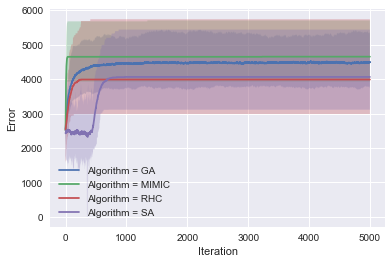

In [16]:
x_arg_name = 'Iteration'
y_arg_name = 'Error'
z_arg_name = 'Algorithm'
filters = {"Problem": ["tsp"]}

cd = consolidate_data_from_db(con, x_arg_name, y_arg_name, z_arg_name, filters)

plt.figure()
for a, d in cd.items():
    plt.plot(d.get(x_arg_name),d.get('median'), 
             label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
    #plt.fill_between(d.get(x_arg_name), d.get('mean') - d.get('std'), d.get('mean') + d.get('std'), alpha=0.3)
    plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel(y_arg_name.replace('_',' '))
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
#plt.savefig("graphs/boost_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+".png")
plt.show()

# Four Peak problem

Selecting data for Algorithm = GA
Selecting data for Algorithm = MIMIC
Selecting data for Algorithm = RHC
Selecting data for Algorithm = SA


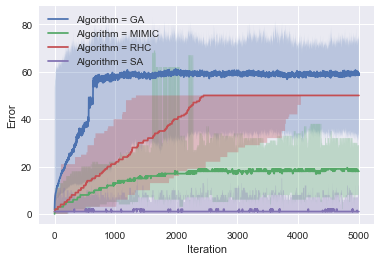

In [17]:
x_arg_name = 'Iteration'
y_arg_name = 'Error'
z_arg_name = 'Algorithm'
filters = {"Problem": ["four_peaks"]}

cd = consolidate_data_from_db(con, x_arg_name, y_arg_name, z_arg_name, filters)

plt.figure()
for a, d in cd.items():
    plt.plot(d.get(x_arg_name),d.get('median'), 
             label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
    #plt.fill_between(d.get(x_arg_name), d.get('mean') - d.get('std'), d.get('mean') + d.get('std'), alpha=0.3)
    plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel(y_arg_name.replace('_',' '))
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
#plt.savefig("graphs/boost_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+".png")
plt.show()

Selecting data for GA_population = 150.0
SELECT Iteration,min(Error) as min,max(Error) as max,median(Error) as median,avg(Error) as mean FROM problems WHERE GA_population = '150.0' AND (Problem='four_peaks') GROUP BY Iteration
Selecting data for GA_population = 50.0
SELECT Iteration,min(Error) as min,max(Error) as max,median(Error) as median,avg(Error) as mean FROM problems WHERE GA_population = '50.0' AND (Problem='four_peaks') GROUP BY Iteration


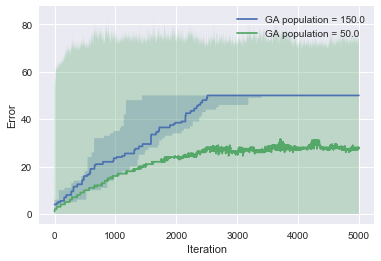

In [32]:
x_arg_name = 'Iteration'
y_arg_name = 'Error'
z_arg_name = 'GA_population'
filters = {'Problem': ['four_peaks'], 'Algorithm': ['GA']}

cd = consolidate_data_from_db(con, x_arg_name, y_arg_name, z_arg_name, filters)

plt.figure()
for a, d in cd.items():
    plt.plot(d.get(x_arg_name),d.get('median'), 
             label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
    #plt.fill_between(d.get(x_arg_name), d.get('mean') - d.get('std'), d.get('mean') + d.get('std'), alpha=0.3)
    plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel(y_arg_name.replace('_',' '))
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
#plt.savefig("graphs/boost_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+".png")
plt.show()

# Knapsack problem

Selecting data for Algorithm = GA
Selecting data for Algorithm = MIMIC
Selecting data for Algorithm = RHC
Selecting data for Algorithm = SA


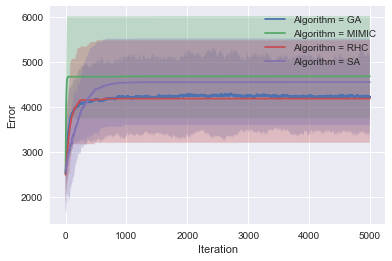

In [18]:
x_arg_name = 'Iteration'
y_arg_name = 'Error'
z_arg_name = 'Algorithm'
filters = {"Problem": ["knapsack"]}

cd = consolidate_data_from_db(con, x_arg_name, y_arg_name, z_arg_name, filters)

plt.figure()
for a, d in cd.items():
    plt.plot(d.get(x_arg_name),d.get('median'), 
             label=z_arg_name.replace('_',' ') + ' = ' + str(a).replace('_',' '))
    #plt.fill_between(d.get(x_arg_name), d.get('mean') - d.get('std'), d.get('mean') + d.get('std'), alpha=0.3)
    plt.fill_between(d.get(x_arg_name), d.get('min'), d.get('max'), alpha=0.3)
plt.ylabel(y_arg_name.replace('_',' '))
plt.xlabel(x_arg_name.replace('_',' '))
plt.legend()
#plt.title("Evolution of acuracy acording to the number of training examples")
#plt.savefig("graphs/boost_"+data_set_name+"_"+x_arg_name+"_"+y_arg_name+"_"+z_arg_name+".png")
plt.show()